In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pprint

import spacy
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

plt.style.use('ggplot')
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/packaging/requirements.py:66: UserWarning: warn_ungrouped_named_tokens_in_collection: setting results name 'specifier' on And expression collides with '_original_end' on contained expression
  VERSION_SPEC = originalTextFor(_VERSION_SPEC)("specifier")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/packaging/requirements.py:69: UserWarning: warn_ungrouped_named_tokens_in_collection: setting results name 'marker' on And expression collides with '_original_end' on contained expression
  MARKER_EXPR = originalTextFor(MARKER_EXPR())("marker")


In [4]:
SALE_PATH = '../otodom-feature-extraction/data/listings_clean_2023-10-16.csv'
RENT_PATH = '../otodom-feature-extraction/data/rent_listings_clean_2023-10-15.csv'
RAW_SALE_PATH = '/Users/Maciek/Desktop/Mieszkania/scrape_listings/otodom_listings/scrape_listings/data/raw/listings_item.csv'

df_sale = pd.read_csv(SALE_PATH)
df_rent = pd.read_csv(RENT_PATH)
df_raw = pd.read_csv(RAW_SALE_PATH)

### SALE DATASET
#### Firstly, I will look at which columns have a lot of 'no data' labels, which mean that the listing did not have particular info in the properties table, to see which information that potentially could be in the description would be beneficial to extract.

<AxesSubplot:>

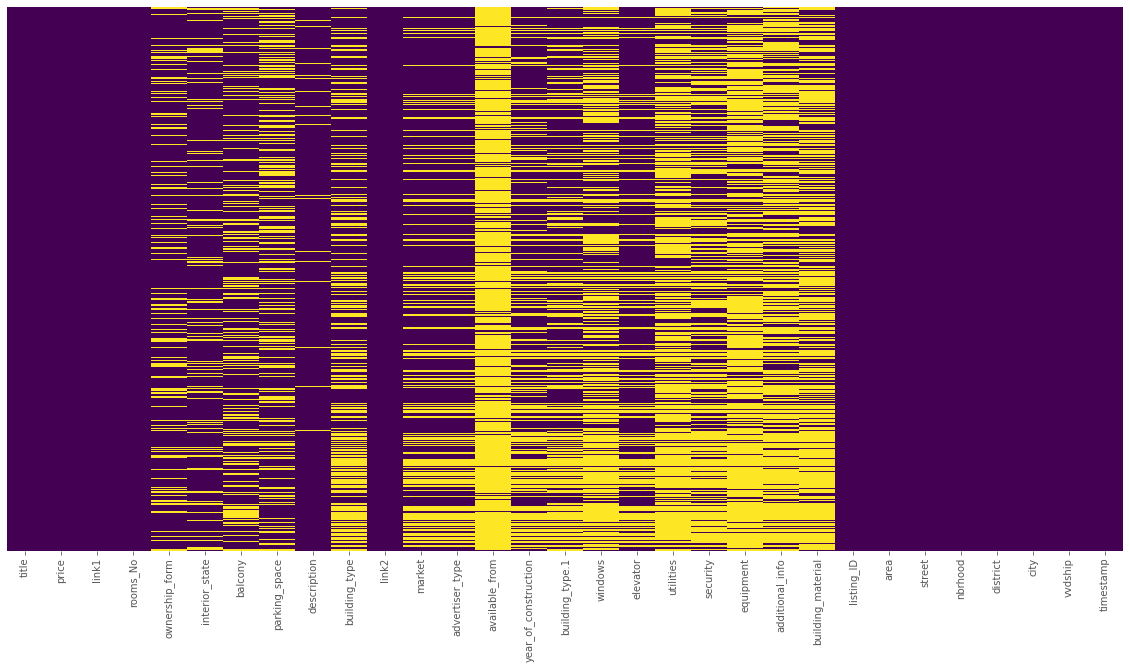

In [5]:
# visualize records that contain value 'no data' in each column and set the figure size to (20, 10)
plt.figure(figsize=(20,10))
sns.heatmap(df_sale=='no data',yticklabels=False,cbar=False,cmap='viridis')


#### There is a large number of columns with missing data. From my experience and intuition, columns which represent information that could be found in the description are:
#### - advertiser_type
#### - building_type
#### - market
#### - elevator
#### - interior_state
#### Additionally, in the description there could be some more useful information not included in the current data:
#### - utitlities & administration costs
#### - proximity to public transport
#### Let's now look at example descriptions

In [6]:
example_desc = df_sale['description'][1]
example_desc

'Dzień dobry. Sprzedam bezpośrednio (AGENCJOM dziękuje) nowoczesne mieszkanie 41 m2, wykończone w wysokim standardzie. 2 pokojowe mieszkanie zlokalizowane na 4-tym piętrze w 4-ro piętrowym budynku z windą z dostępem do rowerowni. Lokal składa się z: - Nowoczesnej, w pełni wyposażonej kuchni w sprzęt AGD (lodówka, piekarnik, płyta indukcyjna, okap, zmywarka), - Salonu łączonego z kuchnią. Salon w pełni umeblowany, - Sypialni z łóżkiem 160x200 ze stelażem unoszonym do góry, pojemną szafą, szafką nocną oraz komodą, - Przestronnej łazienki z prysznicem, toaletą, umywalką oraz dużą lustrzaną zabudową pod pralkę, oświetleniem led osobno zapalanym, podzielony we wnękach podsufitowych, - Przestronnego balkonu z pojemną szafą wnękową z widokiem na tereny zielone. Wejście na balkon możliwe jest z salonu oraz z sypialni, Dodatkowo: Do mieszkania przynależy miejsce postojowe w garażu podziemnym,  dodatkowo płatne 40 000 zł. Budynek oddany do użytku na początku marca 2021 r. Osiedle zamknięte z och

'Dzień dobry. **Sprzedam bezpośrednio (AGENCJOM dziękuje)**[^1] nowoczesne mieszkanie 41 m2, wykończone w wysokim standardzie. 2 pokojowe mieszkanie zlokalizowane na 4-tym piętrze w 4-ro piętrowym budynku **z windą**[^2] z dostępem do rowerowni. Lokal składa się z: - Nowoczesnej, **w pełni wyposażonej**[^3] kuchni w sprzęt AGD (lodówka, piekarnik, płyta indukcyjna, okap, zmywarka), - Salonu łączonego z kuchnią. **Salon w pełni umeblowany**[^3], - **Sypialni z łóżkiem 160x200 ze stelażem unoszonym do góry, pojemną szafą, szafką nocną oraz komodą,**[^3] - Przestronnej łazienki z prysznicem, toaletą, umywalką oraz dużą lustrzaną zabudową pod pralkę, oświetleniem led osobno zapalanym, podzielony we wnękach podsufitowych, - Przestronnego balkonu z pojemną szafą wnękową z widokiem na tereny zielone. Wejście na balkon możliwe jest z salonu oraz z sypialni, Dodatkowo: **Do mieszkania przynależy miejsce postojowe w garażu podziemnym[^4],  dodatkowo płatne 40 000 zł**. **Budynek oddany do użytku na początku marca 2021 r.**[^4] Osiedle zamknięte z ochroną. Na terenie osiedla przynależy duże patio oraz plac zabaw. Obok znajduje się sklep Żabka. Osiedle zlokalizowane jest na granicy Pragi Południe i Gocławia. Mieszkanie znajduje się w pobliżu wielu przystanków autobusowych oraz pętli tramwajowej (bezpośredni dojazd do centrum - 15 min autem, 25 min autobusem).  W okolicy duże centrum handlowe CH King Cross Praga, Castorama (500 m) obok niego siłownia McFit oraz nieco dalej Leroy Merlin i Lidl. Na osiedlu znajduje się sklep Żabka. 1,5 km dalej znajduje się wielkie centrum handlowe Promenada, w którym są sklepy spożywcze, odzieżowe, siłownia oraz kino oraz CH Gocław (2,4 km).'

[^1]: this sentence points to the fact that the listing is directly from the owner (advertiser_type column -> private, fees -> 0%)

[^2]: there is an elevator in the building (elevator -> 1)

[^3]: all point to the furnished apartment and the fact that the place does not need a renovation (interior_state -> good)

[^4]: point to the building type being an apartment building (building_type -> apartamentowiec)

#### As visible in the example above, descriptions can contain numerous useful feature that could be retrieved. To do that, I'll take the approach of text classification using .... 

### 1. Advertiser_type column

### Preprocessing text

<AxesSubplot:>

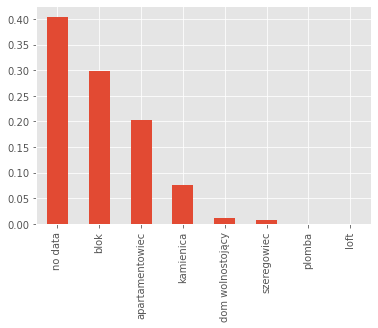

In [7]:
df_sale['building_type'].value_counts(normalize=True).plot(kind='bar')

<AxesSubplot:>

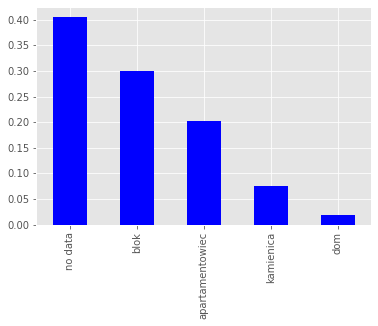

In [11]:
# combine some values from the 'building_type' column
df_sale['building_type'] = df_sale['building_type'].replace({'loft': 'apartamentowiec', 'dom wolnostojący': 'dom', 'plomba': 'dom', 'szeregowiec': 'dom'})
df_sale['building_type'].value_counts(normalize=True).plot(kind='bar', color='blue')


In [12]:
# divide dataset into two dfs: one with records that have advertiser_type value other than 'no data' and the other with records that have advertiser_type value equal to 'no data'
train = df_sale[df_sale['advertiser_type']!='no data']
test = df_sale[df_sale['advertiser_type']=='no data']

In [14]:
# import polish model
nlp = spacy.load('pl_core_news_lg')

In [46]:
# create a function to extract token and pos of each word of the sentence. 
def extract_features(text):
    features = []
    for token in doc:
        features.append({'token': token.text, 'pos': token.pos_})
    return features

features = extract_features(example_desc)
    
# remove stop words and puctuation and lemmitize words
def clean_text(txt):
    doc = nlp(txt)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return tokens


In [49]:
# convert text to vector
vectorizer = CountVectorizer(max_features=1000, min_df=5, max_df=0.8, tokenizer=clean_text)
X = vectorizer.fit_transform(train_X)

In [51]:
# convert bag of words to tf-idf
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()